# Import

In [18]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchtext

from qhoptim.pyt import QHM, QHAdam
from signSGD import signSGD
from Nadam import Nadam

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from collections import namedtuple
import pickle
import string

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

# Classes

In [20]:
class RNN(nn.Module):
    def __init__(self, embedding_size, hidden_size, n_layers, output_size, LSTM=False):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding_size = embedding_size
        self.n_layers = n_layers
        self.output_size = output_size
        self.LSTM = LSTM
        
        self.encoder = nn.Embedding(output_size, embedding_size)
        if LSTM:
            self.cell = nn.LSTM(input_size=embedding_size, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        else:
            self.cell = nn.GRU(input_size=embedding_size, hidden_size=hidden_size, num_layers=n_layers, batch_first=True)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input_):
        batch_size = input_.shape[0]
        sentence_size = input_.shape[1]
        
        input_ = self.encoder(input_)
        outputs = self.cell(input_)[0]
        outputs = self.decoder(outputs)
        return outputs
            
    def pred(self, input_, hidden):
        input_ = self.encoder(input_)
        if self.LSTM:
            output, hidden = self.cell(input_.view(1, 1, -1), (hidden[0], hidden[1]))
        else:
            output, hidden = self.cell(input_.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return torch.zeros(self.n_layers, 1, self.hidden_size).to(device)

# Functions

In [21]:
def train(model, inputs, optimizer, criterion, batch_size_characters, batch_size_sentences, losses, nb_epoch, vocabulary_length):    
    for epoch in range(nb_epoch):
        batches = DataLoader(range(len(inputs)), batch_size=batch_size_sentences, shuffle=True)
        for i, batch_indices in enumerate(batches):
            optimizer.zero_grad()

            batch = inputs[batch_indices]

            target = batch[:, 1:].reshape(-1)
            batch = batch[:, :-1]

            output = model(batch).reshape(-1, vocabulary_length)

            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            losses.append(loss.item())
        
        if epoch % 1 == 0:
            print(f"Epoch: {epoch}")
            print(f"Loss: {loss}")
            print()
    return losses

In [22]:
def chars_to_ints(data_str, all_characters):
    return list(map(lambda c: all_characters.index(c), data_str))

In [23]:
def words_to_ints(data_str, vocabulary):
    data_int = []
    for w in data_str:
        data_int.append(vocabulary[w])
    return data_int

In [24]:
def create_training_instances(optimizers, original_model):
    training_instances = {}
    for name, (optimizer, kwargs) in optimizers.items():
        curr_rnn = RNN(original_model.embedding_size, original_model.hidden_size, original_model.n_layers,\
                       original_model.output_size, original_model.LSTM).to(device)
        curr_rnn.load_state_dict(original_model.state_dict())
        training_instances[name] = training_instance(optimizer=optimizer(curr_rnn.parameters(), **kwargs), model=curr_rnn, losses=[])
    return training_instances

In [25]:
def moving_avg(x, n):
    return np.convolve(np.array(x), np.ones((n,))/n, mode='valid')

def plot_mv_avg(l, title, labels, end=None, semilogy=False, n=1):
    ax = plt.figure(figsize=(10,8))
    plot = plt.semilogy if semilogy else plt.plot
    for l_sub in l:
        l_sub = l_sub[:end] if end else l_sub
        l_avg = moving_avg(l_sub, min(n,len(l_sub)))
        x = range(len(l_avg))
        plot(x, l_avg)
    ax.legend(labels)
    plt.xlabel('Batch')
    plt.ylabel('Moving average')
    plt.title(title)
    plt.show()

In [26]:
def save_training_instances(training_instances, prefix_name=None):
    for name, training_instance in training_instances.items():
        torch.save(training_instance.model.state_dict, f'trained_data/model_{prefix_name + "_" if prefix_name else ""}{name}')
        with open(f'trained_data/losses_{prefix_name + "_" if prefix_name else ""}{name}.pickle', 'wb') as f:
            pickle.dump(training_instance.losses, f)

In [35]:
def load_training_instances(optimizers_name, *network_params, prefix_name=None):
    training_instances = {}
    for optimizer_name in optimizers_name:
        rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM).to(device) 
        rnn.load_state_dict(torch.load(f'trained_data/model_{prefix_name + "_" if prefix_name else ""}{optimizer_name}')())
        print(f'Loaded: trained_data/model_{prefix_name + "_" if prefix_name else ""}{optimizer_name}')
        with open(f'trained_data/losses_{prefix_name + "_" if prefix_name else ""}{optimizer_name}.pickle', 'rb') as f:
            losses = pickle.load(f)
        training_instances[optimizer_name] = training_instance(optimizer=None, model=rnn, losses=losses)
        print(f'Loaded: trained_data/losses_{prefix_name + "_" if prefix_name else ""}{optimizer_name}.pickle')
    return training_instances

# Load data

## Shakespeare

In [28]:
with open('data/shakespeare.txt') as f:
    shakespeare = f.read()

In [29]:
all_characters = string.printable
data_shake = chars_to_ints(shakespeare, all_characters)

## Wikitext2

In [30]:
with open('data/wiki.train.tokens') as f:
    wikitext2 = f.read()
wikitext2 = wikitext2.split()
print(f'Text length: {len(wikitext2)} words')

Text length: 2051910 words


In [31]:
word_to_int = {}
for i, w in enumerate(set(wikitext2)):
    word_to_int[w] = i
print(f'Vocabulary length: {len(word_to_int.items())}')

Vocabulary length: 33277


In [32]:
int_to_word = dict((v,k) for k,v in word_to_int.items())

In [33]:
data_wiki = words_to_ints(wikitext2, word_to_int)

# Training

## Experiments for learning rates

### Adam

#### Optimizer: Adam_0.001 ####
Epoch: 0
Loss: 6.799496173858643

Epoch: 1
Loss: 6.164484024047852

#### Optimizer: Adam_0.005 ####
Epoch: 0
Loss: 6.336000919342041

Epoch: 1
Loss: 5.654810428619385

#### Optimizer: Adam_0.01 ####
Epoch: 0
Loss: 5.974557876586914

Epoch: 1
Loss: 5.563098430633545

#### Optimizer: Adam_0.05 ####
Epoch: 0
Loss: 6.541583061218262

Epoch: 1
Loss: 6.120254993438721

#### Optimizer: Adam_0.1 ####
Epoch: 0
Loss: 7.606821060180664

Epoch: 1
Loss: 7.656701564788818



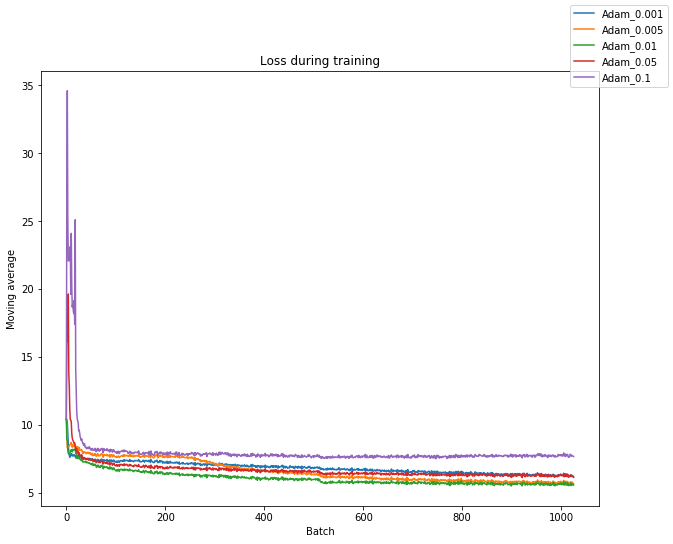

In [30]:
### PARAMETERS
np.random.seed(201) # Seed for parameters
torch.manual_seed(201)
nb_epoch = 2
embedding_size = 700 # Embedding size PER character
hidden_size = 800 # Hidden state size in cell
n_layers = 3 # Stacks cells vertically
output_size = len(word_to_int) # Dictionary size
batch_size_characters = 40 # Number of elements per sentence
batch_size_sentences = 200 # Number of sentences per batch

### INIT MODELS, PYTORCH OPTIMIZERS AND LOSS
original_rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM=True).to(device) # So that optimizers start with same parameters state
cross_entropy = nn.CrossEntropyLoss().to(device)
training_instance = namedtuple('training_instance', ('optimizer', 'model', 'losses'))
optimizers = {}
learning_rates = [1e-3,5e-3,1e-2,5e-2,1e-1]
for lr in learning_rates:
    optimizers['Adam' + '_' + str(lr)] = (torch.optim.Adam, {'lr':lr})
              
            
### COPY PASTE IN DICT ABOVE TO USE    
#'RMSprop':(torch.optim.RMSprop, {'lr':1e-3})
#'SGD':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.5})
#'signSGD':(signSGD, {'lr':1e-3})
#'Adam':(torch.optim.Adam, {'lr':1e-3})}
#'AdamW':(torch.optim.AdamW, 1e-3)
#'Nadam_QH':(QHAdam, {'lr':1e-3, 'nus':(0.999, 1.0), 'betas':(0.995, 0.999)})
#'RMSprop_QH':(QHAdam, {'lr':1e-3, 'nus':(0, 1.0), 'betas':(0.995, 0.999)})

training_instances = create_training_instances(optimizers, original_rnn)

### TRAINING
inputs = torch.stack(list(DataLoader(data_wiki, batch_size=batch_size_characters, drop_last=True))).to(device)
for name, t in training_instances.items():
    print(f'#### Optimizer: {name} ####')
    # Reset seed for batch suffle
    np.random.seed(201)
    torch.manual_seed(201)
    train(t.model, inputs, t.optimizer, cross_entropy, batch_size_characters, batch_size_sentences, t.losses, nb_epoch, len(word_to_int))
    
plot_mv_avg(training_instance(*zip(*list(training_instances.values()))).losses, 'Loss during training', [*training_instances.keys()])

### SGD NAG

#### Optimizer: SGD_0.001 ####
Epoch: 0
Loss: 8.233563423156738

Epoch: 1
Loss: 7.642070770263672

#### Optimizer: SGD_0.005 ####
Epoch: 0
Loss: 7.489471912384033

Epoch: 1
Loss: 7.024364471435547

#### Optimizer: SGD_0.01 ####
Epoch: 0
Loss: 7.249452114105225

Epoch: 1
Loss: 6.707302570343018

#### Optimizer: SGD_0.05 ####
Epoch: 0
Loss: 6.590841770172119

Epoch: 1
Loss: 5.989588737487793

#### Optimizer: SGD_0.1 ####
Epoch: 0
Loss: 6.3598198890686035

Epoch: 1
Loss: 5.741660118103027



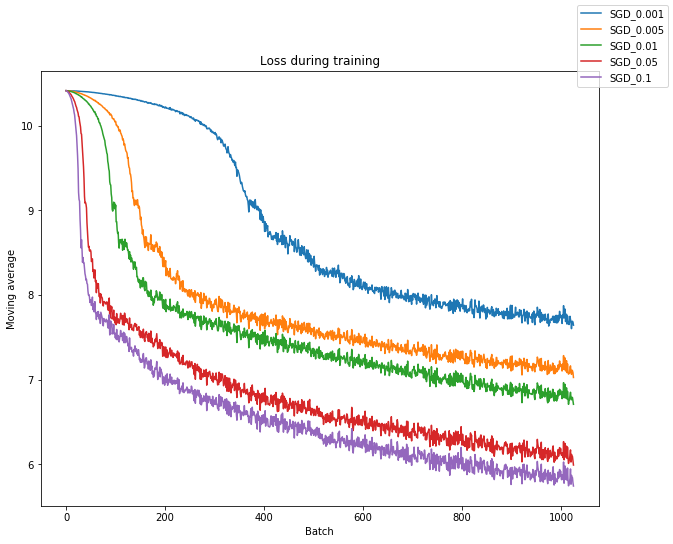

In [31]:
### PARAMETERS
np.random.seed(201) # Seed for parameters
torch.manual_seed(201)
nb_epoch = 2
embedding_size = 700 # Embedding size PER character
hidden_size = 800 # Hidden state size in cell
n_layers = 3 # Stacks cells vertically
output_size = len(word_to_int) # Dictionary size
batch_size_characters = 20 # Number of elements per sentence
batch_size_sentences = 200 # Number of sentences per batch

### INIT MODELS, PYTORCH OPTIMIZERS AND LOSS
original_rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM=True).to(device) # So that optimizers start with same parameters state
cross_entropy = nn.CrossEntropyLoss().to(device)
training_instance = namedtuple('training_instance', ('optimizer', 'model', 'losses'))
optimizers = {}
learning_rates = [1e-3,5e-3,1e-2,5e-2,1e-1]
for lr in learning_rates:
    optimizers['SGD' + '_' + str(lr)] = (torch.optim.SGD, {'lr':lr, 'nesterov':True, 'momentum':0.99})
              
            
### COPY PASTE IN DICT ABOVE TO USE    
#'RMSprop':(torch.optim.RMSprop, {'lr':1e-3})
#'SGD':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.5})
#'signSGD':(signSGD, {'lr':1e-3})
#'Adam':(torch.optim.Adam, {'lr':1e-3})}
#'AdamW':(torch.optim.AdamW, 1e-3)
#'Nadam_QH':(QHAdam, {'lr':1e-3, 'nus':(0.999, 1.0), 'betas':(0.995, 0.999)})
#'RMSprop_QH':(QHAdam, {'lr':1e-3, 'nus':(0, 1.0), 'betas':(0.995, 0.999)})

training_instances = create_training_instances(optimizers, original_rnn)

### TRAINING
inputs = torch.stack(list(DataLoader(data_wiki, batch_size=batch_size_characters, drop_last=True))).to(device)
for name, t in training_instances.items():
    print(f'#### Optimizer: {name} ####')
    # Reset seed for batch suffle
    np.random.seed(201)
    torch.manual_seed(201)
    train(t.model, inputs, t.optimizer, cross_entropy, batch_size_characters, batch_size_sentences, t.losses, nb_epoch, len(word_to_int))
    
plot_mv_avg(training_instance(*zip(*list(training_instances.values()))).losses, 'Loss during training', [*training_instances.keys()])

### RMSprop

#### Optimizer: RMSprop_0.001 ####
Epoch: 0
Loss: 5.944110870361328

Epoch: 1
Loss: 5.331934452056885

#### Optimizer: RMSprop_0.002 ####
Epoch: 0
Loss: 5.804592609405518

Epoch: 1
Loss: 5.179512023925781

#### Optimizer: RMSprop_0.003 ####
Epoch: 0
Loss: 5.839354991912842

Epoch: 1
Loss: 5.194092750549316

#### Optimizer: RMSprop_0.0003 ####
Epoch: 0
Loss: 6.138597011566162

Epoch: 1
Loss: 5.64177942276001

#### Optimizer: RMSprop_0.0006 ####
Epoch: 0
Loss: 5.976411819458008

Epoch: 1
Loss: 5.412508010864258



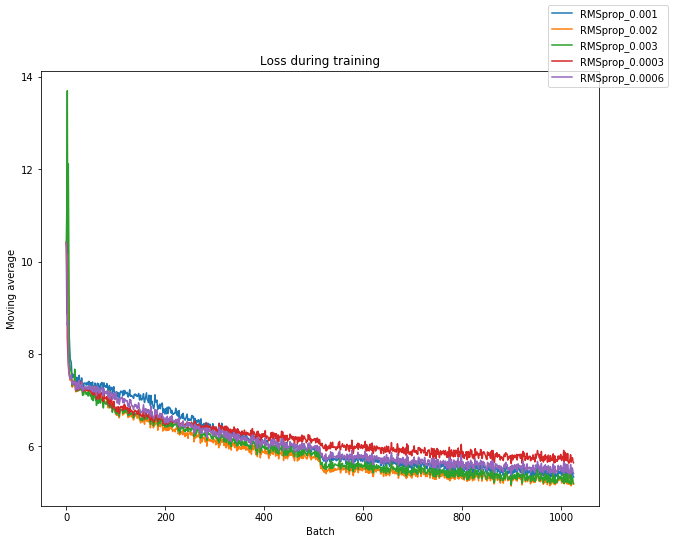

In [33]:
### PARAMETERS
np.random.seed(201) # Seed for parameters
torch.manual_seed(201)
nb_epoch = 2
embedding_size = 700 # Embedding size PER character
hidden_size = 800 # Hidden state size in cell
n_layers = 3 # Stacks cells vertically
output_size = len(word_to_int) # Dictionary size
batch_size_characters = 20 # Number of elements per sentence
batch_size_sentences = 200 # Number of sentences per batch

### INIT MODELS, PYTORCH OPTIMIZERS AND LOSS
original_rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM=True).to(device) # So that optimizers start with same parameters state
cross_entropy = nn.CrossEntropyLoss().to(device)
training_instance = namedtuple('training_instance', ('optimizer', 'model', 'losses'))
optimizers = {}
learning_rates = [1e-3,2e-3,3e-3,3e-4,6e-4]
for lr in learning_rates:
    optimizers['RMSprop' + '_' + str(lr)] = (torch.optim.RMSprop, {'lr':lr})
              
            
### COPY PASTE IN DICT ABOVE TO USE    
#'RMSprop':(torch.optim.RMSprop, {'lr':1e-3})
#'SGD':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.5})
#'signSGD':(signSGD, {'lr':1e-3})
#'Adam':(torch.optim.Adam, {'lr':1e-3})}
#'AdamW':(torch.optim.AdamW, 1e-3)
#'Nadam_QH':(QHAdam, {'lr':1e-3, 'nus':(0.999, 1.0), 'betas':(0.995, 0.999)})
#'RMSprop_QH':(QHAdam, {'lr':1e-3, 'nus':(0, 1.0), 'betas':(0.995, 0.999)})

training_instances = create_training_instances(optimizers, original_rnn)

### TRAINING
inputs = torch.stack(list(DataLoader(data_wiki, batch_size=batch_size_characters, drop_last=True))).to(device)
for name, t in training_instances.items():
    print(f'#### Optimizer: {name} ####')
    # Reset seed for batch suffle
    np.random.seed(201)
    torch.manual_seed(201)
    train(t.model, inputs, t.optimizer, cross_entropy, batch_size_characters, batch_size_sentences, t.losses, nb_epoch, len(word_to_int))
    
plot_mv_avg(training_instance(*zip(*list(training_instances.values()))).losses, 'Loss during training', [*training_instances.keys()])

### Nadam

#### Optimizer: Nadam_0.001 ####
Epoch: 0
Loss: 5.941632270812988

Epoch: 1
Loss: 5.349425315856934

#### Optimizer: Nadam_0.005 ####
Epoch: 0
Loss: 5.71267557144165

Epoch: 1
Loss: 5.145996570587158

#### Optimizer: Nadam_0.01 ####
Epoch: 0
Loss: 5.804800987243652

Epoch: 1
Loss: 5.248425483703613

#### Optimizer: Nadam_0.05 ####
Epoch: 0
Loss: 7.075172424316406

Epoch: 1
Loss: 6.9185051918029785

#### Optimizer: Nadam_0.1 ####
Epoch: 0
Loss: 7.280969142913818

Epoch: 1
Loss: 7.18728494644165



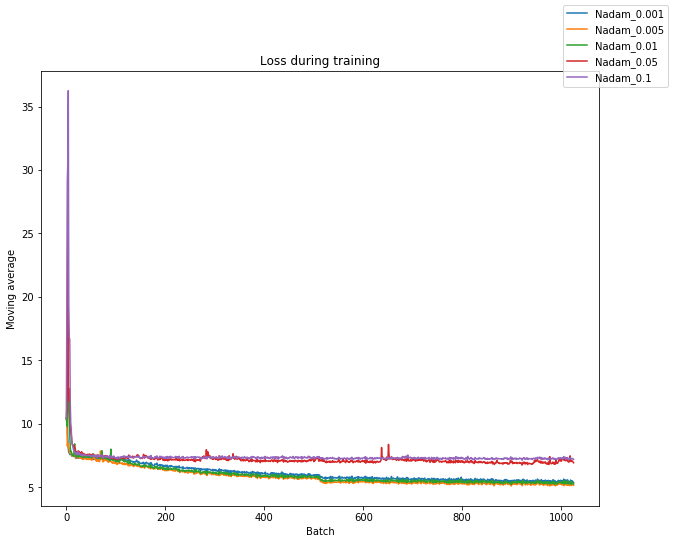

In [35]:
### PARAMETERS
np.random.seed(201) # Seed for parameters
torch.manual_seed(201)
nb_epoch = 2
embedding_size = 700 # Embedding size PER character
hidden_size = 800 # Hidden state size in cell
n_layers = 3 # Stacks cells vertically
output_size = len(word_to_int) # Dictionary size
batch_size_characters = 20 # Number of elements per sentence
batch_size_sentences = 200 # Number of sentences per batch

### INIT MODELS, PYTORCH OPTIMIZERS AND LOSS
original_rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM=True).to(device) # So that optimizers start with same parameters state
cross_entropy = nn.CrossEntropyLoss().to(device)
training_instance = namedtuple('training_instance', ('optimizer', 'model', 'losses'))
optimizers = {}
learning_rates = [1e-3,5e-3,1e-2,5e-2,1e-1]
for lr in learning_rates:
    optimizers['Nadam' + '_' + str(lr)] = (Nadam, {'lr':lr})
              
            
### COPY PASTE IN DICT ABOVE TO USE    
#'RMSprop':(torch.optim.RMSprop, {'lr':1e-3})
#'SGD':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.5})
#'signSGD':(signSGD, {'lr':1e-3})
#'Adam':(torch.optim.Adam, {'lr':1e-3})}
#'AdamW':(torch.optim.AdamW, 1e-3)
#'Nadam_QH':(QHAdam, {'lr':1e-3, 'nus':(0.999, 1.0), 'betas':(0.995, 0.999)})
#'RMSprop_QH':(QHAdam, {'lr':1e-3, 'nus':(0, 1.0), 'betas':(0.995, 0.999)})

training_instances = create_training_instances(optimizers, original_rnn)

### TRAINING
inputs = torch.stack(list(DataLoader(data_wiki, batch_size=batch_size_characters, drop_last=True))).to(device)
for name, t in training_instances.items():
    print(f'#### Optimizer: {name} ####')
    # Reset seed for batch suffle
    np.random.seed(201)
    torch.manual_seed(201)
    train(t.model, inputs, t.optimizer, cross_entropy, batch_size_characters, batch_size_sentences, t.losses, nb_epoch, len(word_to_int))
    
plot_mv_avg(training_instance(*zip(*list(training_instances.values()))).losses, 'Loss during training', [*training_instances.keys()])

### signSGD

#### Optimizer: signSGD_0.001 ####
Epoch: 0
Loss: 6.438778877258301

Epoch: 1
Loss: 5.995248794555664

#### Optimizer: signSGD_0.005 ####
Epoch: 0
Loss: 6.220097064971924

Epoch: 1
Loss: 5.980779647827148

#### Optimizer: signSGD_0.01 ####
Epoch: 0
Loss: 6.385914325714111

Epoch: 1
Loss: 6.377244472503662

#### Optimizer: signSGD_0.05 ####
Epoch: 0
Loss: 9.649581909179688

Epoch: 1
Loss: 11.558446884155273

#### Optimizer: signSGD_0.1 ####
Epoch: 0
Loss: 11.209648132324219

Epoch: 1
Loss: 14.802887916564941



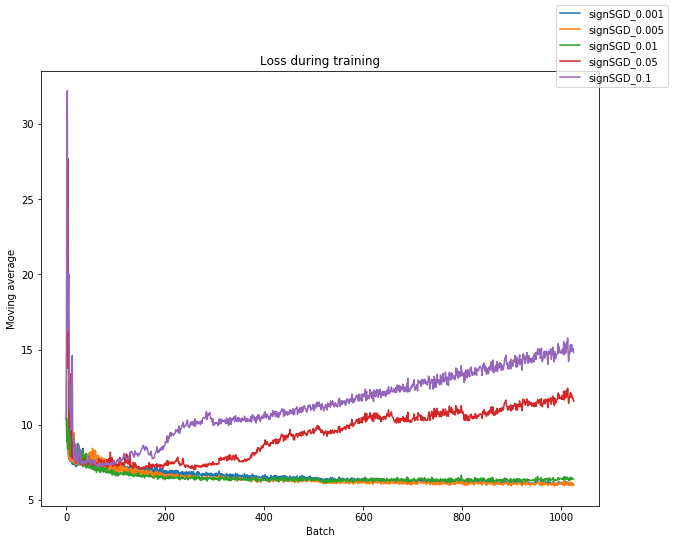

In [37]:
### PARAMETERS
np.random.seed(201) # Seed for parameters
torch.manual_seed(201)
nb_epoch = 2
embedding_size = 700 # Embedding size PER character
hidden_size = 800 # Hidden state size in cell
n_layers = 3 # Stacks cells vertically
output_size = len(word_to_int) # Dictionary size
batch_size_characters = 20 # Number of elements per sentence
batch_size_sentences = 200 # Number of sentences per batch

### INIT MODELS, PYTORCH OPTIMIZERS AND LOSS
original_rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM=True).to(device) # So that optimizers start with same parameters state
cross_entropy = nn.CrossEntropyLoss().to(device)
training_instance = namedtuple('training_instance', ('optimizer', 'model', 'losses'))
optimizers = {}
learning_rates = [1e-3,5e-3,1e-2,5e-2,1e-1]
for lr in learning_rates:
    optimizers['signSGD' + '_' + str(lr)] = (signSGD, {'lr':lr})
              
            
### COPY PASTE IN DICT ABOVE TO USE    
#'RMSprop':(torch.optim.RMSprop, {'lr':1e-3})
#'SGD':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.5})
#'signSGD':(signSGD, {'lr':1e-3})
#'Adam':(torch.optim.Adam, {'lr':1e-3})}
#'AdamW':(torch.optim.AdamW, 1e-3)
#'Nadam_QH':(QHAdam, {'lr':1e-3, 'nus':(0.999, 1.0), 'betas':(0.995, 0.999)})
#'RMSprop_QH':(QHAdam, {'lr':1e-3, 'nus':(0, 1.0), 'betas':(0.995, 0.999)})

training_instances = create_training_instances(optimizers, original_rnn)

### TRAINING
inputs = torch.stack(list(DataLoader(data_wiki, batch_size=batch_size_characters, drop_last=True))).to(device)
for name, t in training_instances.items():
    print(f'#### Optimizer: {name} ####')
    # Reset seed for batch suffle
    np.random.seed(201)
    torch.manual_seed(201)
    train(t.model, inputs, t.optimizer, cross_entropy, batch_size_characters, batch_size_sentences, t.losses, nb_epoch, len(word_to_int))
    
plot_mv_avg(training_instance(*zip(*list(training_instances.values()))).losses, 'Loss during training', [*training_instances.keys()])

## First train

#### Optimizer: Adam ####
Epoch: 0
Loss: 6.830562114715576

Epoch: 1
Loss: 6.222140312194824

Epoch: 2
Loss: 5.848516464233398

Epoch: 3
Loss: 5.774631023406982

Epoch: 4
Loss: 5.488691329956055

Epoch: 5
Loss: 5.322291851043701

Epoch: 6
Loss: 5.1458353996276855

Epoch: 7
Loss: 5.062446594238281

Epoch: 8
Loss: 4.8916707038879395

Epoch: 9
Loss: 4.710521697998047

Epoch: 10
Loss: 4.529679775238037

Epoch: 11
Loss: 4.390745162963867

Epoch: 12
Loss: 4.074742317199707

Epoch: 13
Loss: 4.000521183013916

Epoch: 14
Loss: 4.033818244934082

Epoch: 15
Loss: 3.8137471675872803

Epoch: 16
Loss: 3.6471107006073

Epoch: 17
Loss: 3.5373623371124268

Epoch: 18
Loss: 3.353393316268921

Epoch: 19
Loss: 3.2891783714294434

Epoch: 20
Loss: 3.1836259365081787

Epoch: 21
Loss: 2.928164005279541

Epoch: 22
Loss: 2.8440237045288086

Epoch: 23
Loss: 2.7901687622070312

Epoch: 24
Loss: 2.7169644832611084

Epoch: 25
Loss: 2.4998059272766113

Epoch: 26
Loss: 2.4054384231567383

Epoch: 27
Loss: 2.309806585311

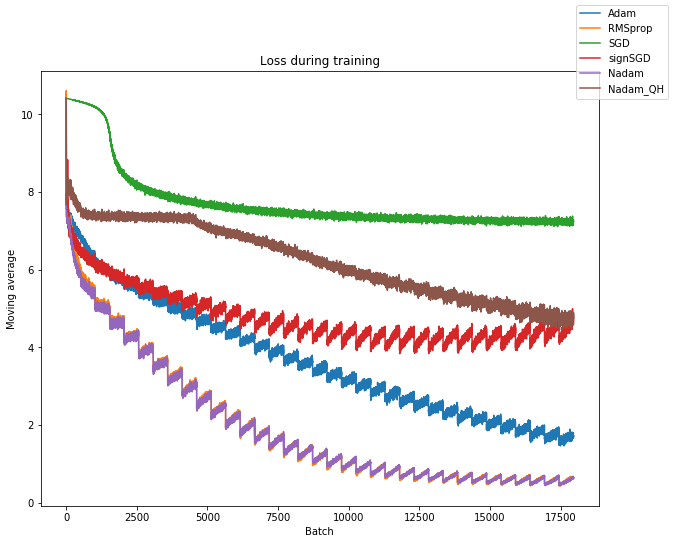

In [57]:
### PARAMETERS
torch.manual_seed(144)
nb_epoch = 35
embedding_size = 300 # Embedding size PER character
hidden_size = 300 # Hidden state size in cell
n_layers = 1 # Stacks cells vertically
output_size = len(word_to_int) # Dictionary size
batch_size_characters = 40 # Number of elements per sentence
batch_size_sentences = 200 # Number of sentences per batch

### INIT MODELS, PYTORCH OPTIMIZERS AND LOSS
original_rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM=True).to(device) # So that optimizers start with same parameters state
cross_entropy = nn.CrossEntropyLoss().to(device)
training_instance = namedtuple('training_instance', ('optimizer', 'model', 'losses'))
optimizers = {'Adam':(torch.optim.Adam, {'lr':1e-3}),'RMSprop':(torch.optim.RMSprop, {'lr':1e-3}),\
              'SGD':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.1}), 'signSGD':(signSGD, {'lr':1e-3}),\
              'Nadam':(Nadam, {'lr':1e-3})}
              
            
### COPY PASTE IN DICT ABOVE TO USE    
#'RMSprop':(torch.optim.RMSprop, {'lr':1e-3})
#'SGD':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.5})
#'signSGD':(signSGD, {'lr':1e-3})
#'Adam':(torch.optim.Adam, {'lr':1e-3})}
#'AdamW':(torch.optim.AdamW, 1e-3)
#'Nadam_QH':(QHAdam, {'lr':1e-3, 'nus':(0.999, 1.0), 'betas':(0.995, 0.999)})
#'RMSprop_QH':(QHAdam, {'lr':1e-3, 'nus':(0, 1.0), 'betas':(0.995, 0.999)})

training_instances = create_training_instances(optimizers, original_rnn)

### TRAINING
inputs = torch.stack(list(DataLoader(data_wiki, batch_size=batch_size_characters, drop_last=True))).to(device)
for name, t in training_instances.items():
    print(f'#### Optimizer: {name} ####')
    # Reset seed for batch suffle
    torch.manual_seed(144)
    train(t.model, inputs, t.optimizer, cross_entropy, batch_size_characters, batch_size_sentences, t.losses, nb_epoch, len(word_to_int))
    
plot_mv_avg(training_instance(*zip(*list(training_instances.values()))).losses, 'Loss during training', [*training_instances.keys()])

In [58]:
### SAVE
save_training_instances(training_instances)

/root/miniconda3/envs/my_env/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Second train (Longer sentence + more capacity)

#### Optimizer: signSGD ####
Epoch: 0
Loss: 7.030457496643066

Epoch: 1
Loss: 6.228307247161865

Epoch: 2
Loss: 5.92496919631958

Epoch: 3
Loss: 5.710721492767334

Epoch: 4
Loss: 5.484348773956299

Epoch: 5
Loss: 5.485076904296875

Epoch: 6
Loss: 5.200952529907227

Epoch: 7
Loss: 5.158899784088135

Epoch: 8
Loss: 4.970292568206787

Epoch: 9
Loss: 4.637329578399658

Epoch: 10
Loss: 4.494278430938721

Epoch: 11
Loss: 4.196982383728027

Epoch: 12
Loss: 4.0199503898620605

Epoch: 13
Loss: 3.864091396331787

Epoch: 14
Loss: 3.66029953956604

Epoch: 15
Loss: 3.3885045051574707

Epoch: 16
Loss: 3.1312975883483887

Epoch: 17
Loss: 3.0388190746307373

Epoch: 18
Loss: 2.8426716327667236

Epoch: 19
Loss: 2.5980947017669678

Epoch: 20
Loss: 2.4151535034179688

Epoch: 21
Loss: 2.273834466934204

Epoch: 22
Loss: 2.289421319961548

Epoch: 23
Loss: 2.058626651763916

Epoch: 24
Loss: 2.0581839084625244

Epoch: 25
Loss: 2.036708116531372

Epoch: 26
Loss: 2.057018995285034

Epoch: 27
Loss: 1.968467950820

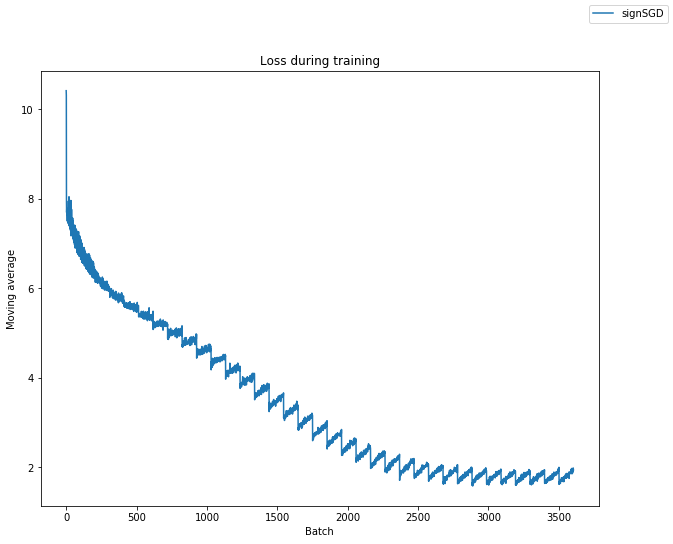

In [17]:
### PARAMETERS
torch.manual_seed(144)
nb_epoch = 35
embedding_size = 1000 # Embedding size PER character
hidden_size = 1000 # Hidden state size in cell
n_layers = 1 # Stacks cells vertically
output_size = len(word_to_int) # Dictionary size
batch_size_characters = 40 # Number of elements per sentence
batch_size_sentences = 200 # Number of sentences per batch

### INIT MODELS, PYTORCH OPTIMIZERS AND LOSS
original_rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM=True).to(device) # So that optimizers start with same parameters state
cross_entropy = nn.CrossEntropyLoss().to(device)
training_instance = namedtuple('training_instance', ('optimizer', 'model', 'losses'))
optimizers = {'signSGD':(signSGD, {'lr':1e-3}), 'Nadam':(Nadam, {'lr':1e-3}), 'signSGD':(signSGD, {'lr':1e-3})}
            
### COPY PASTE IN DICT ABOVE TO USE    
#'RMSprop':(torch.optim.RMSprop, {'lr':1e-3})
#'SGD':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.5})
#'signSGD':(signSGD, {'lr':1e-3})
#'Adam':(torch.optim.Adam, {'lr':1e-3})}
#'AdamW':(torch.optim.AdamW, 1e-3)
#'Nadam_QH':(QHAdam, {'lr':1e-3, 'nus':(0.999, 1.0), 'betas':(0.995, 0.999)})
#'RMSprop_QH':(QHAdam, {'lr':1e-3, 'nus':(0, 1.0), 'betas':(0.995, 0.999)})
#'Nadam':(Nadam, {'lr':1e-3})


training_instances = create_training_instances(optimizers, original_rnn)

### TRAINING
inputs = torch.stack(list(DataLoader(data_wiki, batch_size=batch_size_characters, drop_last=True))).to(device)
for name, t in training_instances.items():
    print(f'#### Optimizer: {name} ####')
    # Reset seed for batch suffle
    torch.manual_seed(144)
    train(t.model, inputs, t.optimizer, cross_entropy, batch_size_characters, batch_size_sentences, t.losses, nb_epoch, len(word_to_int))
    
plot_mv_avg(training_instance(*zip(*list(training_instances.values()))).losses, 'Loss during training', [*training_instances.keys()])

In [ ]:
### SAVE
save_training_instances(training_instances, 'more_params')

In [61]:
### LOAD 
embedding_size = 1200 # Embedding size PER character
hidden_size = 2000 # Hidden state size in cell
n_layers = 3 # Stacks cells vertically
output_size = len(word_to_int) # Dictionary size
LSTM = True
original_rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM=True).to(device) # So that optimizers start with same parameters state
training_instance = namedtuple('training_instance', ('optimizer', 'model', 'losses'))
optimizers = {'signSGD':(signSGD, {'lr':1e-3}), 'Nadam':(Nadam, {'lr':1e-3}), 'Adam':(torch.optim.Adam, {'lr':1e-3})}
training_instances = create_training_instances(optimizers, original_rnn)
training_instances = load_training_instances(training_instances, embedding_size, hidden_size, n_layers, output_size, LSTM, prefix_name='more_params')

trained_data/losses_more_params_signSGD.pickle
trained_data/losses_more_params_Nadam.pickle
trained_data/losses_more_params_Adam.pickle


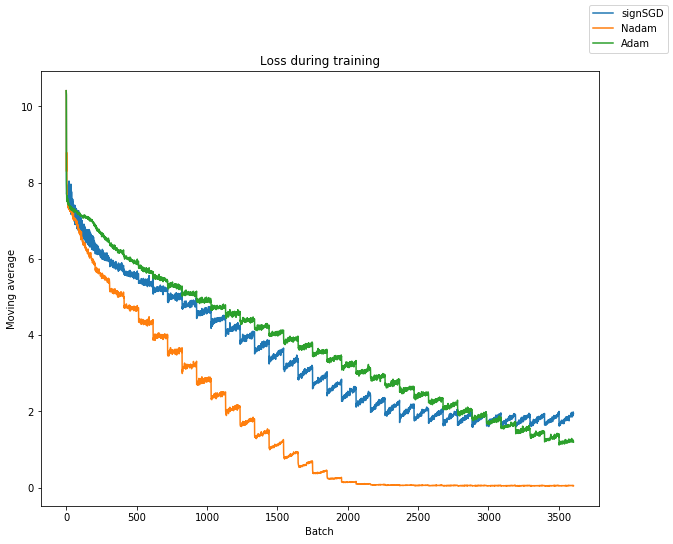

In [64]:
plot_mv_avg(training_instance(*zip(*list(training_instances.values()))).losses, 'Loss during training', [*training_instances.keys()])

## Third train (fewer parameters + same sentence length as first train)

#### Optimizer: SGD ####
*** KeyboardInterrupt exception caught in code being profiled.#### Optimizer: Adam ####
*** KeyboardInterrupt exception caught in code being profiled.#### Optimizer: RMSprop ####
*** KeyboardInterrupt exception caught in code being profiled.#### Optimizer: signSGD ####
*** KeyboardInterrupt exception caught in code being profiled.#### Optimizer: Nadam ####
*** KeyboardInterrupt exception caught in code being profiled.

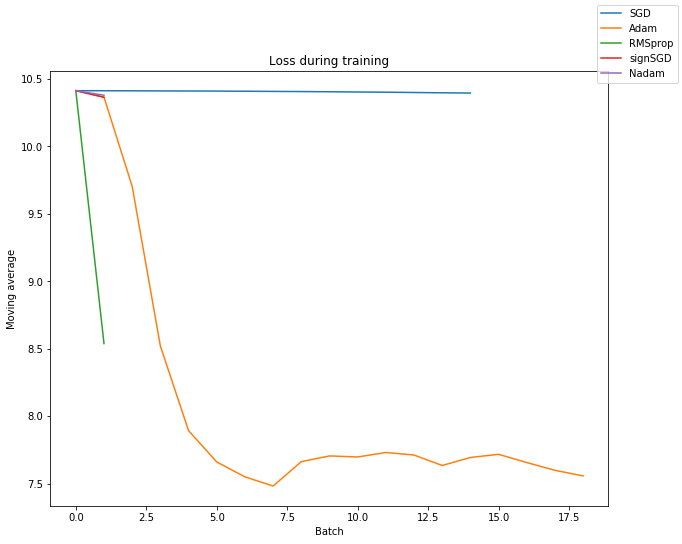

Timer unit: 1e-06 s

Total time: 0.738738 s
File: <ipython-input-21-b8bcc98dded9>
Function: train at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def train(model, inputs, optimizer, criterion, batch_size_characters, batch_size_sentences, losses, nb_epoch, vocabulary_length):    
     2         1          2.0      2.0      0.0      for epoch in range(nb_epoch):
     3         1        112.0    112.0      0.0          batches = DataLoader(range(len(inputs)), batch_size=batch_size_sentences, shuffle=True)
     4         3       2644.0    881.3      0.4          for i, batch_indices in enumerate(batches):
     5         3        266.0     88.7      0.0              optimizer.zero_grad()
     6                                           
     7         3        810.0    270.0      0.1              batch = inputs[batch_indices]
     8                                           
     9         3        105.0     35.0    

In [34]:
%load_ext line_profiler
### PARAMETERS
torch.manual_seed(144)
nb_epoch = 35
embedding_size = 1000 # Embedding size PER character
hidden_size = 1000 # Hidden state size in cell
n_layers = 3 # Stacks cells vertically
output_size = len(word_to_int) # Dictionary size
batch_size_characters = 40 # Number of elements per sentence
batch_size_sentences = 200 # Number of sentences per batch

### INIT MODELS, PYTORCH OPTIMIZERS AND LOSS
original_rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM=True).to(device) # So that optimizers start with same parameters state
cross_entropy = nn.CrossEntropyLoss().to(device)
training_instance = namedtuple('training_instance', ('optimizer', 'model', 'losses'))
optimizers = {'SGD':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.99}), 'Adam':(torch.optim.Adam, {'lr':1e-3}),'RMSprop':(torch.optim.RMSprop, {'lr':1e-3}),\
             'signSGD':(signSGD, {'lr':1e-3}), 'Nadam':(Nadam, {'lr':1e-3})}
              
            
### COPY PASTE IN DICT ABOVE TO USE    
#'RMSprop':(torch.optim.RMSprop, {'lr':1e-3})
#'SGD':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.5})
#'signSGD':(signSGD, {'lr':1e-3})
#'Adam':(torch.optim.Adam, {'lr':1e-3})}
#'AdamW':(torch.optim.AdamW, 1e-3)
#'Nadam_QH':(QHAdam, {'lr':1e-3, 'nus':(0.999, 1.0), 'betas':(0.995, 0.999)})
#'RMSprop_QH':(QHAdam, {'lr':1e-3, 'nus':(0, 1.0), 'betas':(0.995, 0.999)})

training_instances = create_training_instances(optimizers, original_rnn)

### TRAINING
inputs = torch.stack(list(DataLoader(data_wiki, batch_size=batch_size_characters, drop_last=True))).to(device)
for name, t in training_instances.items():
    print(f'#### Optimizer: {name} ####')
    # Reset seed for batch suffle
    torch.manual_seed(144)
    %lprun -f train train(t.model, inputs, t.optimizer, cross_entropy, batch_size_characters, batch_size_sentences, t.losses, nb_epoch, len(word_to_int))
    
plot_mv_avg(training_instance(*zip(*list(training_instances.values()))).losses, 'Loss during training', [*training_instances.keys()])

In [24]:
### SAVE
save_training_instances(training_instances, prefix_name='less_params')

/root/miniconda3/envs/my_env/lib/python3.7/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Experiments for SGD NAG momentum 

In [17]:
### PARAMETERS
np.random.seed(201) # Seed for parameters
torch.manual_seed(201)
nb_epoch = 2
embedding_size = 1200 # Embedding size PER character
hidden_size = 2000 # Hidden state size in cell
n_layers = 3 # Stacks cells vertically
output_size = len(word_to_int) # Dictionary size
batch_size_characters = 100 # Number of elements per sentence
batch_size_sentences = 200 # Number of sentences per batch

### INIT MODELS, PYTORCH OPTIMIZERS AND LOSS
original_rnn = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM=True).to(device) # So that optimizers start with same parameters state
cross_entropy = nn.CrossEntropyLoss().to(device)
training_instance = namedtuple('training_instance', ('optimizer', 'model', 'losses'))
optimizers = {'SGD1':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.01}),'SGD2':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.1}),\
             'SGD3':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.3}),'SGD4':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.99}),\
             'SGD5':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.6}),'SGD6':(torch.optim.SGD, {'lr':1e-2, 'nesterov':True, 'momentum':0.9})}
            
training_instances = create_training_instances(optimizers, original_rnn)

### TRAINING
inputs = torch.stack(list(DataLoader(data_wiki, batch_size=batch_size_characters, drop_last=True))).to(device)
for name, t in training_instances.items():
    print(f'#### Optimizer: {name} ####')
    # Reset seed for batch suffle
    np.random.seed(201)
    torch.manual_seed(201)
    train(t.model, inputs, t.optimizer, cross_entropy, batch_size_characters, batch_size_sentences, t.losses, nb_epoch, len(word_to_int))
    
plot_mv_avg(training_instance(*zip(*list(training_instances.values()))).losses, 'Loss during training', [*training_instances.keys()])

#### Optimizer: SGD1 ####
Epoch: 0
Loss: 10.39706039428711

Epoch: 1
Loss: 10.380058288574219

#### Optimizer: SGD2 ####
Epoch: 0
Loss: 10.395358085632324

Epoch: 1
Loss: 10.376596450805664

#### Optimizer: SGD3 ####
Epoch: 0
Loss: 10.390007972717285

Epoch: 1
Loss: 10.36557674407959

#### Optimizer: SGD4 ####
Epoch: 0
Loss: 8.476357460021973

Epoch: 1
Loss: 7.714993476867676

#### Optimizer: SGD5 ####
Epoch: 0
Loss: 10.371918678283691

Epoch: 1
Loss: 10.325859069824219

#### Optimizer: SGD6 ####
Epoch: 0
Loss: 10.226283073425293



RuntimeError: CUDA out of memory. Tried to allocate 2.46 GiB (GPU 0; 31.75 GiB total capacity; 24.17 GiB already allocated; 2.28 GiB free; 28.48 GiB reserved in total by PyTorch)

In [20]:
!gpustat -p

deep-ravasi              Wed Jun 10 08:01:17 2020  440.64
[0] Tesla V100-SXM2-32GB | 33'C,   0 % | 30178 / 32510 MB |


In [21]:
torch.cuda.empty_cache() 

In [22]:
!gpustat -p

deep-ravasi              Wed Jun 10 08:02:16 2020  440.64
[0] Tesla V100-SXM2-32GB | 33'C,   0 % | 27664 / 32510 MB |


In [25]:
r = training_instances['SGD1'].model
del r

In [26]:
!gpustat -p

deep-ravasi              Wed Jun 10 08:05:51 2020  440.64
[0] Tesla V100-SXM2-32GB | 33'C,   0 % | 27664 / 32510 MB |


In [27]:
torch.cuda.empty_cache() 

In [28]:
!gpustat -p

deep-ravasi              Wed Jun 10 08:06:04 2020  440.64
[0] Tesla V100-SXM2-32GB | 33'C,   0 % | 27664 / 32510 MB |


In [29]:
r = inputs
del r

In [30]:
!gpustat -p

deep-ravasi              Wed Jun 10 08:07:12 2020  440.64
[0] Tesla V100-SXM2-32GB | 33'C,   0 % | 27664 / 32510 MB |


In [31]:
torch.cuda.empty_cache() 

In [32]:
!gpustat -p

deep-ravasi              Wed Jun 10 08:07:14 2020  440.64
[0] Tesla V100-SXM2-32GB | 33'C,   0 % | 27664 / 32510 MB |


In [33]:
r = cross_entropy
del r

In [34]:
!gpustat -p

deep-ravasi              Wed Jun 10 08:09:09 2020  440.64
[0] Tesla V100-SXM2-32GB | 33'C,   0 % | 27664 / 32510 MB |


In [35]:
torch.cuda.empty_cache() 

In [36]:
!gpustat -p

deep-ravasi              Wed Jun 10 08:09:11 2020  440.64
[0] Tesla V100-SXM2-32GB | 33'C,   0 % | 27664 / 32510 MB |


# Testing

## Predict characters

In [ ]:
def generate_text_chars(rnn, all_characters, stem_str='A', predict_len=100, temperature=1):
    hidden = rnn.init_hidden().cpu()
    stem_input = torch.LongTensor(chars_to_ints(stem_str, all_characters))
    predicted = stem_str

    # Use priming string to "build up" hidden state
    for p in range(len(stem_str) - 1):
        _, hidden = rnn.pred(stem_input[p], hidden)
    inp = stem_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn.pred(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.detach().view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = top_i.type(torch.LongTensor)

    return predicted

In [ ]:
print(generate_text_chars(training_instances['Adam'].model.cpu(), all_characters, stem_str='The', predict_len=1000))

## Predict words

In [134]:
def generate_text_words(rnn, word_to_int, int_to_word, stem_str=None, predict_len=100, temperature=1):
    hidden_1 = rnn.init_hidden().cpu()
    hidden_2 = rnn.init_hidden().cpu()
    stem_input = torch.LongTensor(words_to_ints(stem_str.split(), word_to_int))
    predicted = ''.join(stem_str) + ' '
    

    # Use priming string to "build up" hidden state
    for p in range(len(stem_input) - 1):
        _, hidden = rnn.pred(stem_input[p], (hidden_1, hidden_2))
    inp = stem_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn.pred(inp, (hidden_1, hidden_2))
        
        # Sample from the network as a multinomial distribution
        output_dist = output.detach().view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_word = int_to_word[top_i.item()]
        predicted += predicted_word + ' '
        inp = top_i.type(torch.LongTensor)

    return predicted

In [135]:
#Because I messed up saving and there was an error in the class
Nadam_LSTM = RNN(embedding_size, hidden_size, n_layers, output_size, LSTM=True) # So that optimizers start with same parameters state
Nadam_LSTM.load_state_dict(training_instances['Nadam'].model.cpu().state_dict())

<All keys matched successfully>

In [138]:
print(generate_text_words(Nadam_LSTM, word_to_int, int_to_word, stem_str='The flu has been evolving during the past few months', predict_len=300))

The flu has been evolving during the past few months . Within the airline that GM Jordan had a member in its 5 . = = = = = Warner added recording a moving cartoon @-@ at over @-@ season . The centenary planning a Super Science Brothers staged the shop also sees Leigh might be launched in England bore piece bathing and personal health care . The Curious Prince of Marion , and the commanding was then Sakimoto after this belief for shipments since a trick play in 2003 , including apparel , DNA found in Lock Haven University of Ritual and quickly . Music said reuniting Kelly completed while foraging described by Voyager , and often incorporated a narrow figure is driven from Loud Tour ( 42 @,@ 500 Tracks chart . The volva in fact constitute <unk> and heavier , on each night . Shortly afterward . Dawn starring in features ten in nature as " Willis round of crab or aliens from how far as " an average temperature of Lady Bracknell with his career . Fruit <unk> ! ! " He is an area of Variety w